# 2. Baseline CNN Model
\n
Draft and evaluate a custom convolutional neural network for bird vs drone classification in this notebook.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import os
from pathlib import Path

print("✅ TensorFlow version:", tf.__version__)

# Detect project root automatically
root = Path.cwd()
while not (root / "classification_dataset").exists() and root != root.parent:
    root = root.parent

data_dir = root / "classification_dataset"
print("📁 Dataset Root:", data_dir)


✅ TensorFlow version: 2.20.0
📁 Dataset Root: c:\Users\Hamza\Aerial_object\classification_dataset


In [2]:
# Image dimensions
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    data_dir / "train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    data_dir / "valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    data_dir / "test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


In [3]:
def build_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_cnn_model()
model.summary()


c:\Users\Hamza\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("models/cnn_best_model.keras", save_best_only=True, monitor="val_loss")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)


c:\Users\Hamza\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6341 - loss: 0.6444 - val_accuracy: 0.7149 - val_loss: 0.5834
Epoch 2/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 31s 364ms/step - accuracy: 0.7468 - loss: 0.5174 - val_accuracy: 0.7081 - val_loss: 0.5604
Epoch 3/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 361ms/step - accuracy: 0.7814 - loss: 0.4756 - val_accuracy: 0.7760 - val_loss: 0.4439
Epoch 4/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 356ms/step - accuracy: 0.8047 - loss: 0.4365 - val_accuracy: 0.7172 - val_loss: 0.5806
Epoch 5/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 359ms/step - accuracy: 0.8077 - loss: 0.4239 - val_accuracy: 0.7466 - val_loss: 0.4721
Epoch 6/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 358ms/step - accuracy: 0.8088 - loss: 0.4188 - val_accuracy: 0.7511 - val_loss: 0.4945
Epoch 7/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 353ms/step - accuracy: 0.8118 - loss: 0.4012 - val_accuracy: 0.7624 - val_loss: 0.5189
Epoch 8/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 31s 362ms/step - accuracy: 0.8291 - loss: 0.3739 - val_accu

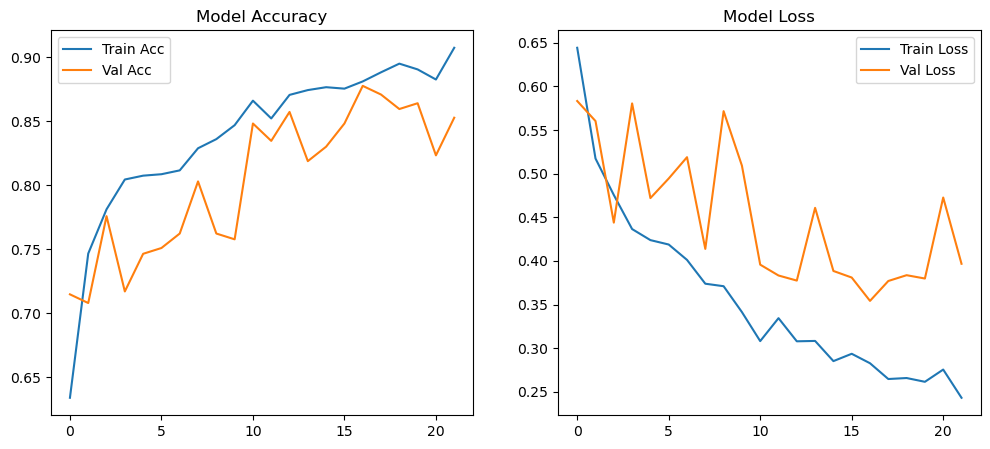

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [6]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8884 - loss: 0.2744
✅ Test Accuracy: 88.84% | Test Loss: 0.2744


In [7]:
model.save("models/final_cnn_model.keras")
print("💾 Model saved to: models/final_cnn_model.keras")


💾 Model saved to: models/final_cnn_model.keras
